Import necessary libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from scipy.stats import randint, uniform
from datetime import datetime

Set random state for reproducibility

In [30]:
RANDOM_STATE = 65

Load dataset

In [31]:
df = pd.read_csv('Champions_Group_2025.csv')

Perform Initial Train-Test Split (20% Untouched for Final Evaluation)

In [32]:
X = df.drop(columns=['Is Domestic Ultimate', 'Is Global Ultimate'])
y = df[['Is Domestic Ultimate', 'Is Global Ultimate']]

# Split into 80% for training and 20% for final model testing
X_train, X_final_test, y_train, y_final_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


Analyse training data (X_train)

<class 'pandas.core.frame.DataFrame'>
Index: 23345 entries, 15470 to 10145
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   LATITUDE                             23254 non-null  float64
 1   LONGITUDE                            23254 non-null  float64
 2   AccountID                            23345 non-null  object 
 3   Company                              23345 non-null  object 
 4   SIC Code                             23345 non-null  int64  
 5   Industry                             23345 non-null  object 
 6   8-Digit SIC Code                     23345 non-null  int64  
 7   8-Digit SIC Description              23345 non-null  object 
 8   Year Found                           23001 non-null  float64
 9   Parent Company                       22934 non-null  object 
 10  Parent Country                       22929 non-null  object 
 11  Ownership Type               

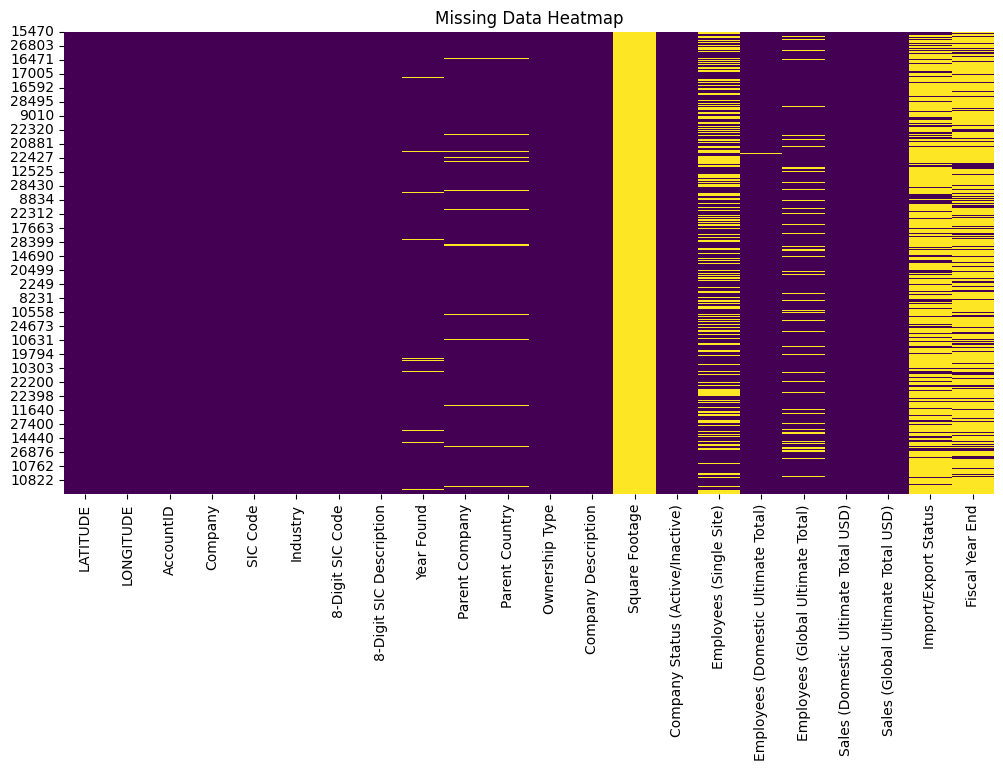

In [33]:
# Dataset info
print(X_train.info())

# Count missing values
missing_values = X_train.isnull().sum()
missing_percentage = (missing_values / len(X_train)) * 100

# Display missing values in descending order
missing_data = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage})
missing_data = missing_data.sort_values(by="Missing Values", ascending=False)
print(missing_data)

# Visualizing missing data
plt.figure(figsize=(12, 6))
sns.heatmap(X_train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

Fill missing values in X_train

In [34]:
# Fill missing values for Year Found using Industry-wise Median
X_train['Year Found'] = X_train.groupby('Industry')['Year Found'].transform(lambda x: x.fillna(x.median()))

# Fill missing values for LATITUDE & LONGITUDE using KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)
X_train[['LATITUDE', 'LONGITUDE']] = knn_imputer.fit_transform(X_train[['LATITUDE', 'LONGITUDE']])

"""Predict & Fill Missing Employee Data using RandomForestRegressor"""

# Encode categorical columns temporarily before using them in the model
categorical_columns = ['Industry', 'Ownership Type']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))  # Convert to string before encoding
    label_encoders[col] = le  # Save encoders to decode later

# Select features for predicting missing employee values
employee_features = ['Industry', 'Ownership Type', 'Sales (Domestic Ultimate Total USD)']

# Fill missing values for 'Employees (Global Ultimate Total)' and 'Employees (Domestic Ultimate Total)'
for target in ['Employees (Global Ultimate Total)', 'Employees (Domestic Ultimate Total)']:
    known_data = X_train[X_train[target].notnull()]
    unknown_data = X_train[X_train[target].isnull()]

    if not unknown_data.empty:  # Proceed only if there are missing values
        rf_model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
        rf_model.fit(known_data[employee_features], known_data[target])

        # Predict and fill missing values
        X_train.loc[X_train[target].isnull(), target] = rf_model.predict(unknown_data[employee_features])

# Decode categorical columns back to original labels
for col in categorical_columns:
    X_train[col] = label_encoders[col].inverse_transform(X_train[col])

Add new features into data

In [35]:
X_train["Employees' Ratio (Domestic / Global)"] = X_train["Employees (Domestic Ultimate Total)"] / X_train["Employees (Global Ultimate Total)"]
X_train["Sales' Ratio (Domestic / Global)"] = X_train["Sales (Domestic Ultimate Total USD)"] / X_train["Sales (Global Ultimate Total USD)"]
X_train["Age"] = X_train["Year Found"].apply(lambda x: datetime.now().year - x)

Drop columns that should not be in the final dataset

In [36]:
drop_columns = [
    "AccountID", "Company", "Parent Company", "Company Description", "8-Digit SIC Description",
    "Square Footage", "Import/Export Status", "Fiscal Year End",
    "Employees (Single Site)", "Company Status (Active/Inactive)", "Year Found",
    "Parent Country"
]
X_train.drop(columns=drop_columns, inplace=True)

print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 23345 entries, 15470 to 10145
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   LATITUDE                              23345 non-null  float64
 1   LONGITUDE                             23345 non-null  float64
 2   SIC Code                              23345 non-null  int64  
 3   Industry                              23345 non-null  object 
 4   8-Digit SIC Code                      23345 non-null  int64  
 5   Ownership Type                        23345 non-null  object 
 6   Employees (Domestic Ultimate Total)   23345 non-null  float64
 7   Employees (Global Ultimate Total)     23345 non-null  float64
 8   Sales (Domestic Ultimate Total USD)   23345 non-null  float64
 9   Sales (Global Ultimate Total USD)     23345 non-null  float64
 10  Employees' Ratio (Domestic / Global)  23345 non-null  float64
 11  Sales' Ratio (Do

Encode categorical features & Standardize numerical features

In [37]:
# Identify categorical and numerical features again after dropping columns
categorical_features = ["SIC Code", "Industry", "8-Digit SIC Code", "Ownership Type"]
numerical_features = ["LATITUDE", "LONGITUDE", "Employees (Domestic Ultimate Total)", "Employees (Global Ultimate Total)",
                      "Sales (Domestic Ultimate Total USD)", "Sales (Global Ultimate Total USD)",
                      "Employees' Ratio (Domestic / Global)", "Sales' Ratio (Domestic / Global)", "Age"]

# Define column transformer: Standardize numerical features, One-hot encode categorical features
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

Analysing Correlation

LATITUDE                                float64
LONGITUDE                               float64
SIC Code                                  int16
Industry                                  int16
8-Digit SIC Code                          int16
Ownership Type                             int8
Employees (Domestic Ultimate Total)     float64
Employees (Global Ultimate Total)       float64
Sales (Domestic Ultimate Total USD)     float64
Sales (Global Ultimate Total USD)       float64
Employees' Ratio (Domestic / Global)    float64
Sales' Ratio (Domestic / Global)        float64
Age                                     float64
dtype: object


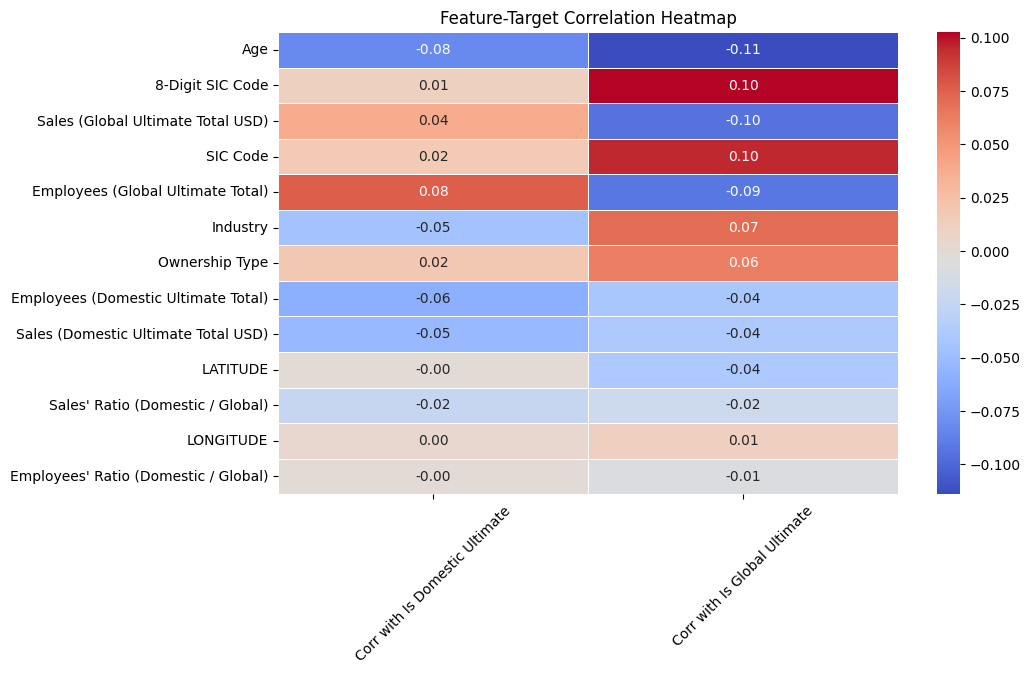

In [38]:
### **1. Convert Categorical Variables to Ordinal Encoding**
categorical_columns = ["SIC Code", "Industry", "8-Digit SIC Code", "Ownership Type"]

for col in categorical_columns:
    X_train[col] = X_train[col].astype("category").cat.codes  # Convert to numerical codes

print(X_train.dtypes)
### **2. Compute Correlation Between Features and Target Variables**
correlation_matrix = X_train.corrwith(y_train["Is Domestic Ultimate"]).to_frame(name="Corr with Is Domestic Ultimate")
correlation_matrix["Corr with Is Global Ultimate"] = X_train.corrwith(y_train["Is Global Ultimate"])

# Sort by absolute correlation values for better visualization
correlation_matrix["max_corr"] = correlation_matrix.abs().max(axis=1)  # Max correlation for sorting
correlation_matrix = correlation_matrix.sort_values(by="max_corr", ascending=False).drop(columns=["max_corr"])

### **3. Plot Heatmap**
plt.figure(figsize=(10, 6))  # Adjust figure size
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Feature-Target Correlation Heatmap")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.show()

Print class distribution before balancing

In [39]:
print("\nClass distribution before balancing:")
print(y_train['Is Domestic Ultimate'].value_counts(normalize=True))
print(y_train['Is Global Ultimate'].value_counts(normalize=True))


Class distribution before balancing:
Is Domestic Ultimate
1    0.500064
0    0.499936
Name: proportion, dtype: float64
Is Global Ultimate
0    0.742771
1    0.257229
Name: proportion, dtype: float64


pply SMOTE for Handling Class Imbalance

In [40]:
# Apply Preprocessor Transformation Before SMOTE
X_train_encoded = preprocessor.fit_transform(X_train)

# Initialize SMOTE
smote = SMOTE(random_state=RANDOM_STATE)

# Apply SMOTE separately for each target using transformed `X_train_encoded`
X_train_resampled_dom, y_train_resampled_dom = smote.fit_resample(X_train_encoded, y_train['Is Domestic Ultimate'])
X_train_resampled_glob, y_train_resampled_glob = smote.fit_resample(X_train_encoded, y_train['Is Global Ultimate'])

# Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

# Convert back to DataFrame with correct column names
X_train_resampled_dom = pd.DataFrame(X_train_resampled_dom, columns=feature_names)
X_train_resampled_glob = pd.DataFrame(X_train_resampled_glob, columns=feature_names)

# Convert target values back to Pandas Series
y_train_resampled_dom = pd.Series(y_train_resampled_dom, name="Is Domestic Ultimate")
y_train_resampled_glob = pd.Series(y_train_resampled_glob, name="Is Global Ultimate")

# Get common indices after resampling
common_indices = np.intersect1d(y_train_resampled_dom.index, y_train_resampled_glob.index)

# Keep only common samples (now `.loc[]` will work)
X_train_resampled = X_train_resampled_dom.iloc[common_indices].reset_index(drop=True)
y_train_resampled = pd.DataFrame({
    'Is Domestic Ultimate': y_train_resampled_dom.iloc[common_indices].values,
    'Is Global Ultimate': y_train_resampled_glob.iloc[common_indices].values
})

Print class distribution after balancing

In [41]:
print("\nClass distribution after balancing:")
print(y_train_resampled['Is Domestic Ultimate'].value_counts(normalize=True))
print(y_train_resampled['Is Global Ultimate'].value_counts(normalize=True))


Class distribution after balancing:
Is Domestic Ultimate
1    0.5
0    0.5
Name: proportion, dtype: float64
Is Global Ultimate
0    0.742676
1    0.257324
Name: proportion, dtype: float64


Information of Final Training Data

In [42]:
print(X_train_resampled.info())
print(y_train_resampled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23348 entries, 0 to 23347
Columns: 3193 entries, num__LATITUDE to cat__Ownership Type_5
dtypes: float64(3193)
memory usage: 568.8 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23348 entries, 0 to 23347
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Is Domestic Ultimate  23348 non-null  int64
 1   Is Global Ultimate    23348 non-null  int64
dtypes: int64(2)
memory usage: 364.9 KB
None


Define models and hyperparameter spaces

In [43]:
models = {
    "Random Forest": {
        "model": MultiOutputClassifier(RandomForestClassifier(random_state=RANDOM_STATE)),
        "params": {
            "estimator__n_estimators": randint(50, 200),
            "estimator__max_depth": randint(5, 30),
            "estimator__min_samples_split": randint(2, 10),
            "estimator__min_samples_leaf": randint(1, 10),
        }
    },
    "Logistic Regression": {
        "model": MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)),
        "params": {
            "estimator__C": uniform(0.01, 10),
            "estimator__penalty": ["l1", "l2"],
            "estimator__solver": ["liblinear"]
        }
    },
    "XGBoost": {
        "model": MultiOutputClassifier(XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric="logloss")),
        "params": {
            "estimator__n_estimators": randint(50, 200),
            "estimator__max_depth": randint(3, 10),
            "estimator__learning_rate": uniform(0.01, 0.3),
            "estimator__subsample": uniform(0.7, 0.3)
        }
    }
}


Perform Randomized Search for Hyperparameter Tuning

In [ ]:
best_models = {}
for name, config in models.items():
    print(f"\nTraining {name}...")

    search = RandomizedSearchCV(
        config["model"],
        config["params"],
        n_iter=10,
        cv=3,
        scoring='f1_micro',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    search.fit(X_train_resampled, y_train_resampled)
    best_models[name] = search.best_estimator_
    print(f"Best Parameters for {name}: {search.best_params_}")


Training Random Forest...
Best Parameters for Random Forest: {'estimator__max_depth': 20, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 7, 'estimator__n_estimators': 151}

Training Logistic Regression...
Best Parameters for Logistic Regression: {'estimator__C': 5.713628894906507, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:57:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'estimator__learning_rate': 0.20534763668538228, 'estimator__max_depth': 9, 'estimator__n_estimators': 151, 'estimator__subsample': 0.9051988306486374}


Evaluate models using Precision-Recall Curve

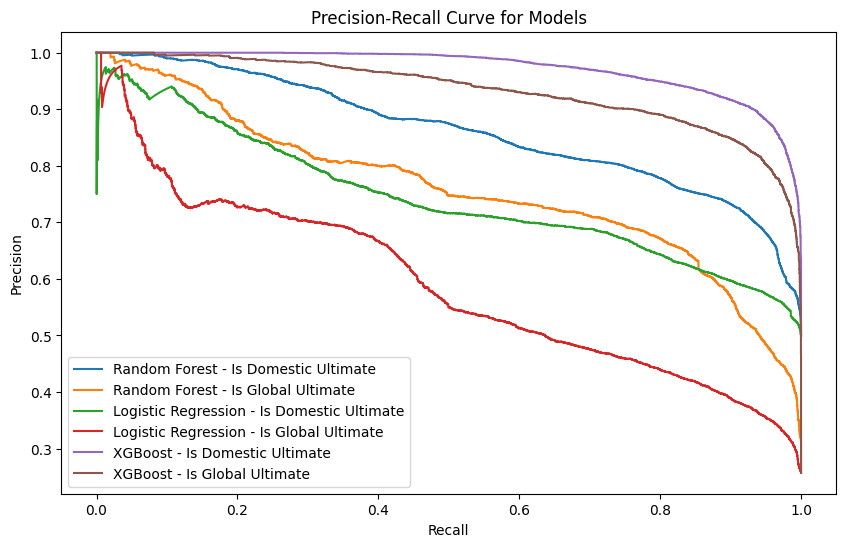

In [ ]:
plt.figure(figsize=(10, 6))
for name, model in best_models.items():
    y_scores = model.predict_proba(X_train_resampled)
    for i, label in enumerate(y_train_resampled.columns):
        precision, recall, _ = precision_recall_curve(y_train_resampled.iloc[:, i], y_scores[i][:, 1])
        plt.plot(recall, precision, label=f"{name} - {label}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Models")
plt.legend()
plt.show()

Function to compute evaluation metrics including PR AUC

In [ ]:
def evaluate_model(model, X, y_true):
    """Evaluates a model and returns metrics including PR AUC"""
    y_pred = model.predict(X)
    y_scores = model.predict_proba(X)

    metrics = {}
    for i, col in enumerate(y_true.columns):
        precision, recall, _ = precision_recall_curve(y_true.iloc[:, i], y_scores[i][:, 1])
        pr_auc = auc(recall, precision)

        metrics[col] = {
            "Accuracy": accuracy_score(y_true.iloc[:, i], y_pred[:, i]),
            "Precision": precision_score(y_true.iloc[:, i], y_pred[:, i]),
            "Recall": recall_score(y_true.iloc[:, i], y_pred[:, i]),
            "F1 Score": f1_score(y_true.iloc[:, i], y_pred[:, i]),
            "PR AUC": pr_auc
        }

    return metrics

Compute Metrics for Each Model

In [ ]:
all_metrics = {}
for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    all_metrics[name] = evaluate_model(model, X_train_resampled, y_train_resampled)


Evaluating Random Forest...

Evaluating Logistic Regression...

Evaluating XGBoost...


Print Performance Metrics for Each Mode

In [ ]:
print("\n📊 Model Performance Metrics:\n")
for model_name, results in all_metrics.items():
    print(f"\n🔹 {model_name} Performance:")
    for target, metrics in results.items():
        print(f"\nTarget: {target}")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")


📊 Model Performance Metrics:


🔹 Random Forest Performance:

Target: Is Domestic Ultimate
Accuracy: 0.7824
Precision: 0.7942
Recall: 0.7625
F1 Score: 0.7780
PR AUC: 0.8624

Target: Is Global Ultimate
Accuracy: 0.8131
Precision: 0.8086
Recall: 0.3587
F1 Score: 0.4969
PR AUC: 0.7610

🔹 Logistic Regression Performance:

Target: Is Domestic Ultimate
Accuracy: 0.6872
Precision: 0.6629
Recall: 0.7619
F1 Score: 0.7089
PR AUC: 0.7441

Target: Is Global Ultimate
Accuracy: 0.7846
Precision: 0.7068
Recall: 0.2785
F1 Score: 0.3995
PR AUC: 0.5892

🔹 XGBoost Performance:

Target: Is Domestic Ultimate
Accuracy: 0.9132
Precision: 0.8921
Recall: 0.9400
F1 Score: 0.9155
PR AUC: 0.9721

Target: Is Global Ultimate
Accuracy: 0.9329
Precision: 0.8503
Recall: 0.8973
F1 Score: 0.8732
PR AUC: 0.9331


Select Best Model Based on PR AUC

In [ ]:
best_model_name = max(best_models, key=lambda name:
                      sum(all_metrics[name][col]["PR AUC"] for col in y_train_resampled.columns))
best_model = best_models[best_model_name]

print(f"\n✅ Best Model Selected: {best_model_name} (Based on PR AUC)")


✅ Best Model Selected: XGBoost (Based on PR AUC)


Final Model Training on Full Training Data

In [ ]:
best_model.fit(X_train_resampled, y_train_resampled)

Function to preprocess test data before evaluation

In [ ]:
def preprocess_test_data(test_data, preprocessor):
    """Preprocess the test data using the same transformations as training."""

    # Fill missing values for Year Found using Industry-wise Median
    test_data['Year Found'] = test_data.groupby('Industry')['Year Found'].transform(lambda x: x.fillna(x.median()))

    # Fill missing values for LATITUDE & LONGITUDE using KNN Imputer
    knn_imputer = KNNImputer(n_neighbors=5)
    test_data[['LATITUDE', 'LONGITUDE']] = knn_imputer.fit_transform(test_data[['LATITUDE', 'LONGITUDE']])

    # Predict & Fill Missing Employee Data using RandomForestRegressor
    categorical_columns = ['Industry', 'Ownership Type']
    label_encoders = {}

    for col in categorical_columns:
        le = LabelEncoder()
        test_data[col] = le.fit_transform(test_data[col].astype(str))  # Convert to string before encoding
        label_encoders[col] = le  # Save encoders to decode later

    employee_features = ['Industry', 'Ownership Type', 'Sales (Domestic Ultimate Total USD)']

    for target in ['Employees (Global Ultimate Total)', 'Employees (Domestic Ultimate Total)']:
        known_data = test_data[test_data[target].notnull()]
        unknown_data = test_data[test_data[target].isnull()]

        if not unknown_data.empty:
            rf_model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
            rf_model.fit(known_data[employee_features], known_data[target])
            test_data.loc[test_data[target].isnull(), target] = rf_model.predict(unknown_data[employee_features])

    # Decode categorical columns back to original labels
    for col in categorical_columns:
        test_data[col] = label_encoders[col].inverse_transform(test_data[col])

    # Add new features into data
    test_data["Employees' Ratio (Domestic / Global)"] = test_data["Employees (Domestic Ultimate Total)"] / test_data["Employees (Global Ultimate Total)"]
    test_data["Sales' Ratio (Domestic / Global)"] = test_data["Sales (Domestic Ultimate Total USD)"] / test_data["Sales (Global Ultimate Total USD)"]
    test_data["Age"] = test_data["Year Found"].apply(lambda x: datetime.now().year - x)

    # Drop unnecessary columns
    test_data = test_data.drop(columns=[
        "AccountID", "Company", "Parent Company", "Company Description", "8-Digit SIC Description",
        "Square Footage", "Import/Export Status", "Fiscal Year End",
        "Employees (Single Site)", "Company Status (Active/Inactive)", "Year Found"
    ])

    # Apply preprocessor transformation
    test_data_transformed = np.array(preprocessor.transform(test_data))

    return test_data_transformed

Preprocess the Final Test Data

In [ ]:
X_final_test_processed = preprocess_test_data(X_final_test, preprocessor)

Final Evaluation on X_final_test

In [ ]:
y_final_pred = best_model.predict(X_final_test_processed)

Compute final performance metrics

In [ ]:
final_metrics = {}
for i, col in enumerate(y_final_test.columns):
    final_metrics[col] = {
        "Accuracy": accuracy_score(y_final_test.iloc[:, i], y_final_pred[:, i]),
        "Precision": precision_score(y_final_test.iloc[:, i], y_final_pred[:, i]),
        "Recall": recall_score(y_final_test.iloc[:, i], y_final_pred[:, i]),
        "F1 Score": f1_score(y_final_test.iloc[:, i], y_final_pred[:, i])
    }

Display final results

In [ ]:
for target, scores in final_metrics.items():
    print(f"\nFinal Model Performance for {target}:")
    for metric, value in scores.items():
        print(f"{metric}: {value:.4f}")


Final Model Performance for Is Domestic Ultimate:
Accuracy: 0.6880
Precision: 0.6848
Recall: 0.6968
F1 Score: 0.6908

Final Model Performance for Is Global Ultimate:
Accuracy: 0.7468
Precision: 0.5097
Recall: 0.4208
F1 Score: 0.4610


Save the Final Model

In [ ]:
joblib.dump(best_model, "model.joblib")
print("\n✅ Best model saved as model.joblib")